# South Australia Solar Supply Forecast

---

This project aims to forecast energy supply from solar photovoltaic (PV) in South Australia. This is my first attempt at exploring Energy and Environmental topic, and may yield useful information to anticipate potential grid volatility.

### Data Source

Our data is collected with [OpenNEM API](https://opennem.org.au/) and [Open Meteo API](https://open-meteo.com/), made available under [CC BY 4.0 License](https://creativecommons.org/licenses/by/4.0/).

### Analysis Tool

We will be using Python 3 (Numpy, Pandas, Matplotlib) and [Nixtla's StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/) library in this project.

---

## Importing File

We import the file `extracted.csv` which is extracted from OpenNEM and Open Meteo's API. The extracting script can be found as `script_etl.py` on the same folder, which samples the daily data from 5 January 2019 to 5 January 2024 for various solar plants in South Australia.

Albeit sometimes considered data leaking, looking at the general plots seem to be so quintessential in time series analysis for detecting error that I decided not to put verification data at least for this part.

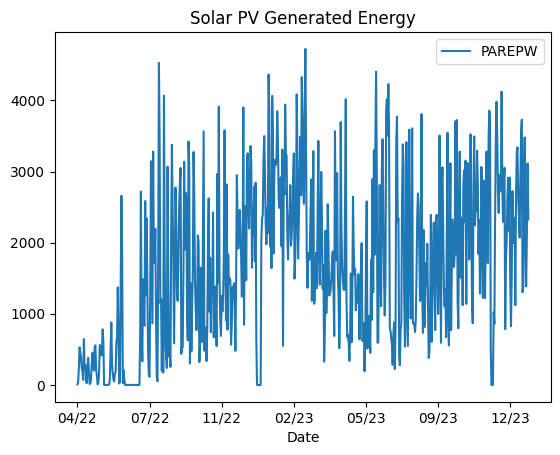

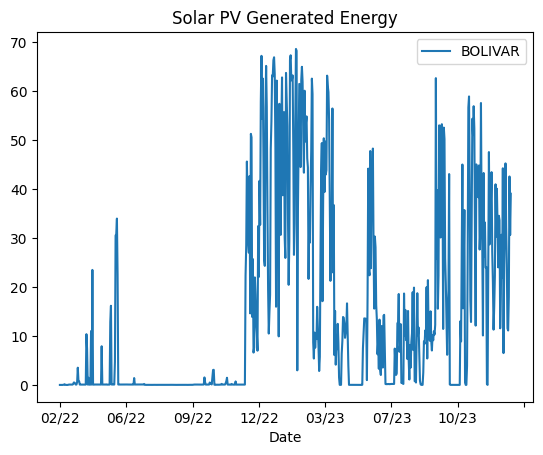

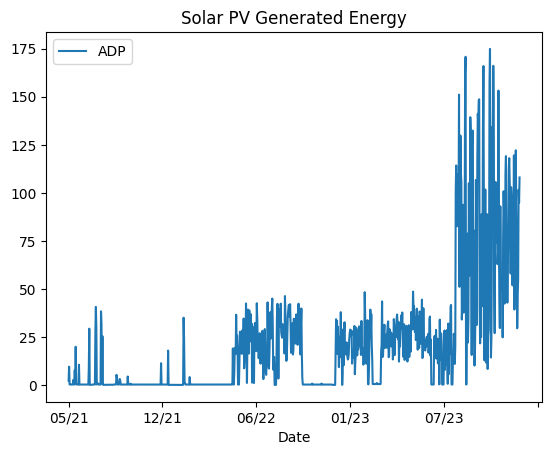

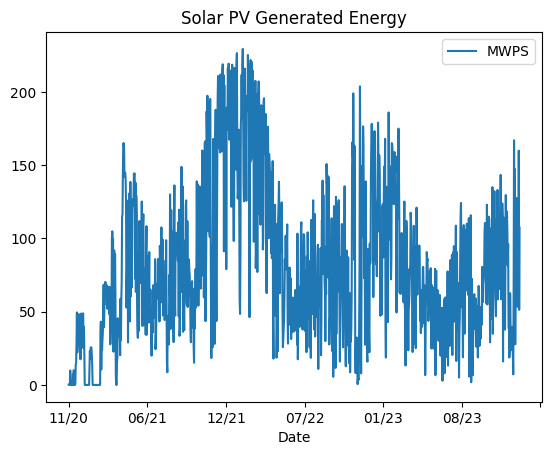

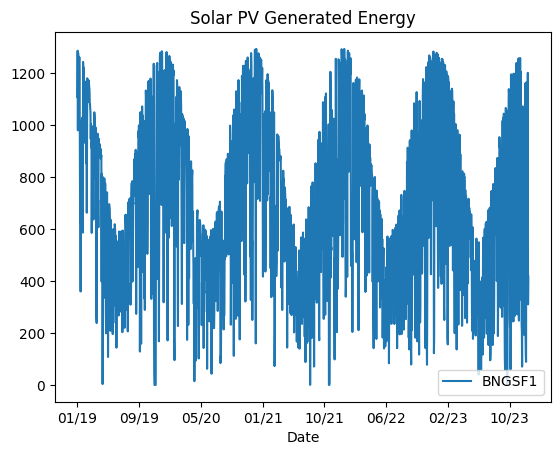

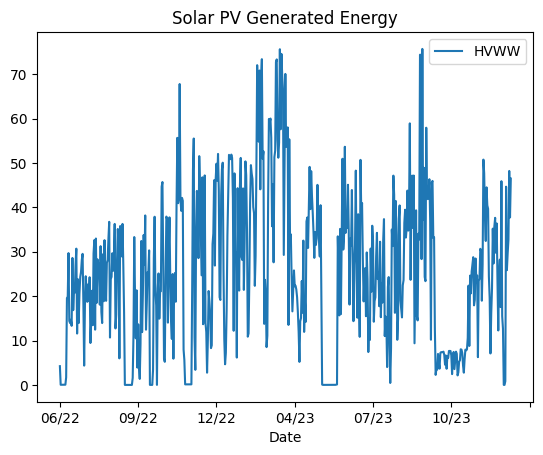

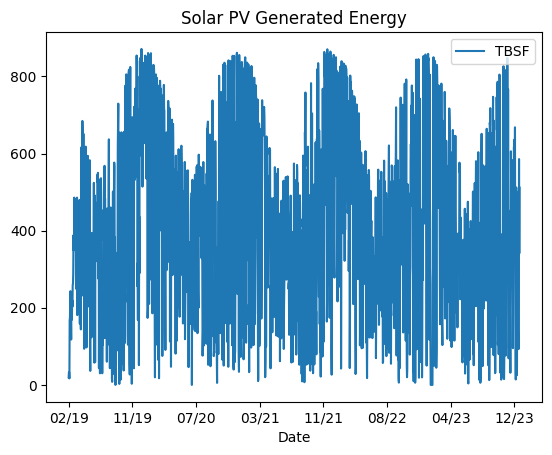

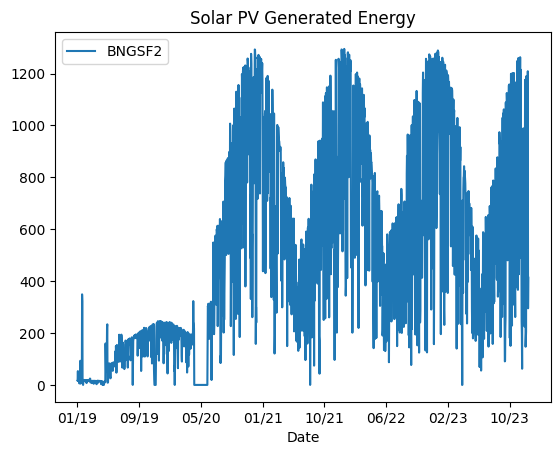

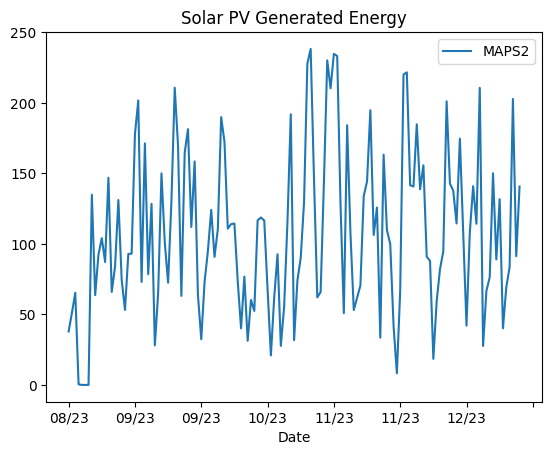

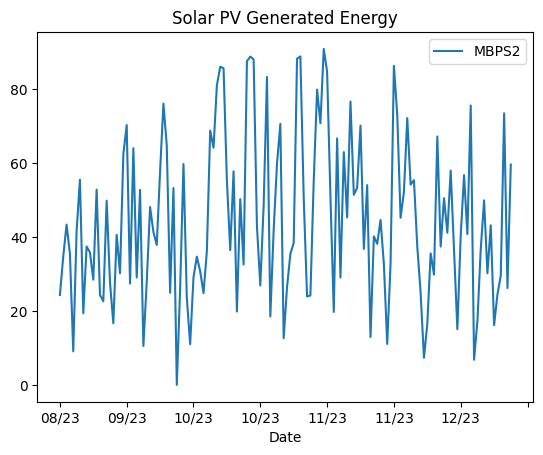

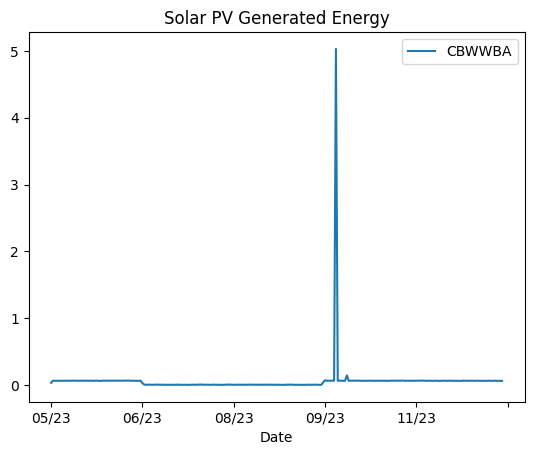

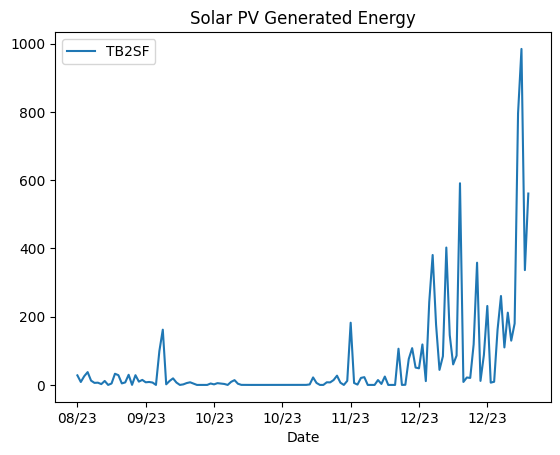

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from os.path import isfile
import pickle

# Import data
sol = pd.read_csv("sol_data.csv")

# Select the data from establishment dates (actually should be in ETL)
for name in sol["Name"].unique():
    start_date_idx = sol[sol["Name"] == name].index[0]
    est_date_idx = sol[(sol["Name"] == name) & (sol["Energy"] > 0)].index[0]
    sol.drop(index = list(range(start_date_idx, est_date_idx)), inplace=True)

# Preview plot
for name in sol["Name"].unique():
    plt.close()
    df = sol[sol["Name"] == name]
    df.loc[:, 'Date'] = pd.to_datetime(df["Date"], yearfirst=True).dt.strftime('%m/%y') # only change format for this loop
    df.plot(x='Date', y='Energy', label=name)
    plt.title("Solar PV Generated Energy")
    plt.legend()
    plt.show()

We can get several impressions:

* Some areas have very seasonal data such as `BNGSF1`, some have smaller number of data points such as `MAPS2`, `MBPS2`, `TB2SF`. The area code `CBWWBA` have extremely sparse data.

* Looking at the seasonal data being capped from above, it seems that the seasonal-trend decomposition would be multiplicative.

* Some secondary plants marked with `2` suffix might be related to their primary plant, so I am thinking of predicting both areas at once.

## Time Series Modeling

We will use several time series models such as:


1. Baseline models: naive model, seasonal-naive model (one year, i.e. 365.25 days extrapolated), naive with drift term, window average (7 days).

    These are simple enough to be implemented in-house and can be easily adjusted for missing values.


2. Statistical models: theta's method, exponential smoothing (ETS), autoregressive integrated moving average (ARIMA, max p, q = 5), Croston's method.

    Theta model is picked due to its high accuracy in various competition such as M5, while Croston is picked for being able to handle intermmitent series.

    We incorporate temperature and solar irradiance as exogenous factors into the ARIMA model.


3. Machine learning models: LightGBM for fast performance.

    The very well-known LSTM is not used here particularly because the well known libraries such as `TensorFlow` requires additional hardware requirement (i.e. graphic card) which not everyone will necessarily have by default, while using CPU will usually be too slow.


4. Ensemble model: simply averaging out with no regards to weighting.


We use RMSE and AIC as accuracy metrics for our model, and pick the best model for each solar plant location in South Australia.


In [8]:
# === Model

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, RandomWalkWithDrift, WindowAverage, \
                                 AutoTheta, AutoETS, AutoARIMA, CrostonOptimized
from mlforecast import MLForecast
from lightgbm import LGBMRegressor

h = 3

# Change header for modelling library
sol_sf = sol[["Name", "Date", "Energy", "Temperature", "Solar Irradiance"]] \
                .replace("", np.nan).dropna() \
                .rename(columns = {
                    "Name": "unique_id",
                    "Date": "ds",
                    "Energy": "y"
                })

models = [Naive(), SeasonalNaive(365), RandomWalkWithDrift(), WindowAverage(7), \
          AutoTheta(), AutoETS(), AutoARIMA(), CrostonOptimized()]
sf = StatsForecast(models, freq="D", df=sol_sf)

/home/rotisayabundar/.local/lib/python3.8/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
# === Cross-validation

# Based on short vs long time series
# For simplicity, load the objects from Pickle

ds_counts = sol_sf.groupby("unique_id").size()
ds_count_limit = 500
sol_sf_filter = sol_sf["unique_id"].isin(ds_counts[ds_counts > ds_count_limit].index)
sol_sf_long = sol_sf[sol_sf_filter]
sol_sf_short = sol_sf[-sol_sf_filter]
if not isfile("save_model.pkl"):
    # combined cv results
    cv_sol_sf_long = sf.cross_validation(df=sol_sf_long, h=h, n_windows=5, step_size = 100) \
                        .reset_index()
    cv_sol_sf_short = sf.cross_validation(df=sol_sf_short, h=h, n_windows=5, step_size = 10) \
                        .reset_index()
    cv_sol_sf = pd.concat([cv_sol_sf_long, cv_sol_sf_short])
    with open('save_model.pkl', 'wb') as outp:
        pickle.dump(cv_sol_sf, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open('save_model.pkl', 'rb') as inp:
        cv_sol_sf = pickle.load(inp)

# Ensemble result
cv_sol_sf["h"] = (cv_sol_sf["ds"] - cv_sol_sf["cutoff"]).dt.days
cv_sol_sf["EnsembleBaseline"] = cv_sol_sf.loc[:, "Naive":"WindowAverage"].mean(axis=1)
cv_sol_sf["EnsembleAll"] = cv_sol_sf.loc[:, "Naive":"CrostonOptimized"].mean(axis=1)

print(cv_sol_sf)

   unique_id                  ds              cutoff           y     Naive  \
0        ADP 2022-11-27 04:00:00 2022-11-26 04:00:00    0.192000    0.1920   
1        ADP 2022-11-28 04:00:00 2022-11-26 04:00:00    0.192000    0.1920   
2        ADP 2022-11-29 04:00:00 2022-11-26 04:00:00    0.192000    0.1920   
3        ADP 2023-03-07 04:00:00 2023-03-06 04:00:00    0.448600    1.0057   
4        ADP 2023-03-08 04:00:00 2023-03-06 04:00:00    0.419100    1.0057   
..       ...                 ...                 ...         ...       ...   
55     TB2SF 2023-12-23 04:00:00 2023-12-21 04:00:00  231.399994   11.8000   
56     TB2SF 2023-12-24 04:00:00 2023-12-21 04:00:00    6.667000   11.8000   
57     TB2SF 2024-01-01 04:00:00 2023-12-31 04:00:00  796.099976  180.0000   
58     TB2SF 2024-01-02 04:00:00 2023-12-31 04:00:00  984.700012  180.0000   
59     TB2SF 2024-01-03 04:00:00 2023-12-31 04:00:00  336.500000  180.0000   

    SeasonalNaive         RWD  WindowAverage   AutoTheta     Au

In [11]:
# === Accuracy

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mse

def evaluate_cross_validation(df, metrics): #Simplify soon?
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y', 'h']).columns.tolist()
    evals = []
    for cutoff in df['cutoff'].unique():
        df_smp = df[df['cutoff'] == cutoff]
        for h in df_smp['h'].unique():
            df_smp_smp = df_smp[df_smp['h'] == h]
            eval_ = evaluate(df_smp_smp, metrics=metrics, models=models)
            eval_['h'] = h
            evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby(["unique_id", "metric", "h"]).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals.reset_index()

# AIC, BIC soon
error_sol_sf = evaluate_cross_validation(cv_sol_sf, [mape, mse]) # ignore SeasonalNaive when 0
print(error_sol_sf)

   unique_id metric  h          Naive  SeasonalNaive            RWD  \
0        ADP   mape  1       0.397290       0.463344       0.400711   
1        ADP   mape  2       1.899838       0.436166       1.909914   
2        ADP   mape  3       0.412706       0.628034       0.423058   
3        ADP    mse  1     386.909210     972.581055     389.384827   
4        ADP    mse  2    3215.889404    1546.615479    3227.662598   
..       ...    ... ..            ...            ...            ...   
67      TBSF   mape  2      11.385960       7.956800      11.399472   
68      TBSF   mape  3      21.597364      14.788740      21.636360   
69      TBSF    mse  1   27545.275391  128216.023438   27581.222656   
70      TBSF    mse  2  241785.156250  116213.539062  242048.531250   
71      TBSF    mse  3  146245.375000  110871.046875  146305.015625   

    WindowAverage     AutoTheta       AutoETS     AutoARIMA  CrostonOptimized  \
0        0.171880      0.318728      0.278924      1.467186       

In [12]:
# Collect final predictions: STILLSOMESSY

final = cv_sol_sf[cv_sol_sf["cutoff"] == max(cv_sol_sf["cutoff"].unique())]
final = final.merge(error_sol_sf[error_sol_sf['metric'] == "mse"][["unique_id", "h", "best_model"]], \
                    on=["unique_id", "h"], how="outer")
final = final.melt(id_vars = ["unique_id", "ds", "best_model"])
preds = final[final["best_model"] == final["variable"]] \
            .drop(columns="variable") \
            .sort_values(by = ["unique_id", "ds"]) \
            .rename(columns = {"value": "y"})
hists = sol_sf

print(preds)

    unique_id                  ds        best_model            y
396       ADP 2024-01-01 04:00:00  EnsembleBaseline    46.327145
181       ADP 2024-01-02 04:00:00     WindowAverage    67.991142
218       ADP 2024-01-03 04:00:00         AutoTheta     63.91304
183    BNGSF1 2024-01-01 04:00:00     WindowAverage   546.698547
112    BNGSF1 2024-01-02 04:00:00     SeasonalNaive       1272.0
293    BNGSF1 2024-01-03 04:00:00         AutoARIMA   147.196732
186    BNGSF2 2024-01-01 04:00:00     WindowAverage   600.042847
115    BNGSF2 2024-01-02 04:00:00     SeasonalNaive       1279.0
296    BNGSF2 2024-01-03 04:00:00         AutoARIMA   245.830627
441   BOLIVAR 2024-01-01 04:00:00       EnsembleAll    21.597504
406   BOLIVAR 2024-01-02 04:00:00  EnsembleBaseline    21.094707
335   BOLIVAR 2024-01-03 04:00:00  CrostonOptimized    20.383728
348    CBWWBA 2024-01-01 04:00:00  CrostonOptimized     0.065247
205    CBWWBA 2024-01-02 04:00:00     WindowAverage     0.065249
206    CBWWBA 2024-01-03 

In [64]:
# Try generating Optimal Ensemble

from scipy.optimize import minimize, Bounds

def regularised_sum_se(w, y, X, a):
    return np.linalg.norm(y - X @ w)**2 + a*np.linalg.norm(w)**2

curr_loc = "ADP"
curr_h = 1
y = cv_sol_sf.loc[(cv_sol_sf["unique_id"] == curr_loc) & (cv_sol_sf["h"] == curr_h), "y"]
X = cv_sol_sf.loc[(cv_sol_sf["unique_id"] == curr_loc) & (cv_sol_sf["h"] == curr_h), "Naive":"CrostonOptimized"]
w0 = np.array(8*[1]) / 8
a = 0.5
bound = Bounds(8 * [0], 8 * [1])
cons = {"type" : "eq", "fun": lambda w: np.sum(w) - 1}
        
res = minimize(lambda w: regularised_sum_se(w, y, X, a), w0, bounds=bound, constraints=cons, options={'disp': True})
res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.677687830451783
            Iterations: 8
            Function evaluations: 76
            Gradient evaluations: 8


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.677687830451783
       x: [ 5.011e-02  2.257e-01  2.613e-02  2.523e-15  1.532e-01
            2.514e-01  2.934e-01  0.000e+00]
     nit: 8
     jac: [ 1.616e+01  1.616e+01  1.616e+01  1.801e+01  1.617e+01
            1.617e+01  1.617e+01  1.935e+01]
    nfev: 76
    njev: 8

## Visualisation

Note that the prediction is currently for up to three days based on historical data, so in general forecasts for later days are less accurate than the early ones.

Accuracy rank: MWPS, BNGSF; ADP MAPS, MBPS, MWPS; etc; TB2SF

In [114]:
# === Basic visualisation

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

def sol_points(unique_id):
    curr_hists = hists[hists["unique_id"] == unique_id]
    curr_preds = preds[preds["unique_id"] == unique_id]
    return(dict(x = [curr_hists["ds"][-60:-h], curr_hists["ds"][-(h+1):], pd.concat([curr_hists["ds"][-(h+1):-h], curr_preds["ds"]])],
                y = [curr_hists["y"][-60:-h], curr_hists["y"][-(h+1):], pd.concat([curr_hists["y"][-(h+1):-h], curr_preds["y"]])],
                visible = True))

curr_loc = "ADP"
curr_sol_points = sol_points(curr_loc)
fig = go.Figure()
fig.add_trace(go.Scatter(x = curr_sol_points["x"][0], y = curr_sol_points["y"][0], mode='lines', name = "Historic"))
fig.add_trace(go.Scatter(x = curr_sol_points["x"][1], y = curr_sol_points["y"][1], mode='lines', name = "Actual"))
fig.add_trace(go.Scatter(x = curr_sol_points["x"][2], y = curr_sol_points["y"][2], mode='lines', name = "Forecast"))
fig.update_layout(barmode = 'overlay', template = "plotly_white")
fig.update_layout(
    updatemenus = [dict(direction = "down",
                        buttons = [dict(args=[sol_points(loc)],
                                        label=loc,
                                        method="restyle") for loc in sol["Name"].unique()],
                        pad = {"r": 10, "t": 10}, showactive =True,
                        x = 0.11, xanchor="left", y = 1.1, yanchor = "top")]
)
fig